In [59]:
cd /mnt/Data/Workspaces/Eclipse/dataAnalysis/Sleep-current/

/mnt/Data/Workspaces/Eclipse/dataAnalysis/Sleep-current


In [60]:
import sys
extraPaths=["/home/chenani/pypacks/lib/python2.7/site-packages",
    "/mnt/Data/Scripts/Sleep-Oct14/src/",
    "/home/haas/.local/lib/"]
for p in extraPaths:
    if not sys.path.count(p):
        sys.path.insert(1, p)


In [61]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as pl
import pickle as pkl
import Recordings
import signale,trajectory
import extras.trees
import os
import fnmatch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading engine for T files

In [62]:
###################################################### initialization
###################################################### Parameters
expType = 'real'
prefix = ''
suffix = ''
noSpeck = False
onlyRunning = True
showHeadDir = False
saveFigs = True
useRecommended = False
TTName = '.t'

# initialize in order to make them available globally
spikes=[]
ID=-1
stList=signale.spikezugList(t_start=None, t_stop=None, dims=[2])
traj = None
eventData = None

cwd=os.getcwd()


###################################################### functions

def getData(folderName):
    global spikes, ID, traj, eventData

    if os.path.isdir(folderName):
        dirList=os.listdir(folderName)
        os.chdir(folderName)
    else:
        dirList = [folderName]
    for item in sorted(dirList):
        if os.path.isfile(item):
            if (TTName.__class__ == list and item in TTName) or\
                    (TTName.__class__ == str and item.endswith(suffix+'.t') and item.startswith(prefix)):
                print 'loading', item , 'from folder: '+folderName
                spikes = signale.load_tFile(item, showHeader=False)
                ID += 1
                stList.__setitem__(ID, spikes)
                stList.addTags(ID, file=item, dir=folderName)
            # real
            elif expType == 'real':
                if item.endswith('.nvt'):   ## or item.endswith('2.ncs'):
                    print 'loading', item , 'from folder: '+folderName
                    loadedSomething = True
                    traj = trajectory.load_nvtFile(item, 'linearMaze', showHeader=False)
                    HDtraj = traj[1]        # head direction
                    traj = traj[0]          # trajectory
        elif os.path.isdir(item):
            getData(item)
    os.chdir('..')


In [63]:
def locate(pattern, root=os.curdir):
    '''
    Locate all files matching supplied filename pattern in and below
        supplied root directory.
    Parameters
    ----------
        pattern : string
            A string representing pattern you want to look for in the path.
        root : string
            contains the path address you want to look trough!
    Returns
    ----------
        Array of strings consist of two column, first contains the path and second the file names that matched 
        the desired pattern.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]

def nvt_loader(filename):
    """ 
    Memory map the Neuralynx .nvt format
    Fields
    -------
    swstx
    swid
    sw_data_size
    qTimeStamps       Cheetah timestamp for this record. This value is in microseconds.
    dwpoints          Points with the color bitfield values for this record.This is a 400
                      element array.  See Video Tracker in reference. 
    sncrc
    dnextracted_x     Extracted X location of the target being tracked. 
    dnextracted_y     Extracted Y location of the target being tracked.
    dnextracted_angle The calculated head angle in degrees clockwise from the positive Y
                      axis. Zero will be assigned if angle tracking is disabled.
    dnTargets         Colored targets using the samebitfield format used by the dwPoints array.
                      Instead of transitions, the bitfield indicates the colors that make up 
                      each particular target and the center point of that target.  This is a 50
                      element array sorted by size from largest (index 0) to smallest(index 49).
                      A target value of 0 means that no target is present in thatindex location.
                      See Video Tracker Bitfield Information in reference. 
    
    Reference:
    ----------
        http://neuralynx.com/software/NeuralynxDataFileFormats.pdf
    """ 
    nev_dtype = np.dtype([
        ('swstx'              , '<i2'),
        ('swid'               , '<i2'),
        ('sw_data_size'       , '<i2'),
        ('qTimeStamps'        , '<u8'),
        ('dwPoints'           , '<u4',(400,)),
        ('sncrc'              , '<i2'),
        ('dnextracted_x'      , '<i4'),
        ('dnextracted_y'      , '<i4'),
        ('dnextracted_angle'  , '<i4'),
        ('dnTargets'          , '<i4',(50,)),
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='readwrite',
       offset=(16 * 2**10))
def nev_loader(filename):
    """ Memory map the Neuralynx .nev format """ 
    nev_dtype = np.dtype([
        ('nstx'           , '<i2'),
        ('npkt_id'        , '<i2'),
        ('npkt_data_size' , '<i2'),
        ('qTimeStamps'    , '<u8'),
        ('nevent_id'      , '<i2'),
        ('nttl'           , '<i2'),
        ('ncrc'           , '<i2'),
        ('ndummy1'        , '<i2'),
        ('ndummy2'        , '<i2'),
        ('dnExtra'        , '<i4',(8,)),
        ('String'         , '<S128')
    ])
    return np.memmap(filename, dtype=nev_dtype, mode='r',
       offset=(16 * 2**10))

In [64]:
traj = None
HDtraj = None
def getTraj(trajFile):
    global traj
    global HDtraj
    print 'loading', trajFile
    traj = trajectory.load_nvtFile(trajFile, 'linearMaze', showHeader=False)
    HDtraj = traj[1]        # head direction
    traj = traj[0]          # trajectory

In [65]:
vtList = sorted([os.path.join(item[0],item[1]) for item in locate('*.nvt',rat3656D1)])
vtList = [item for item in vtList if item.split('/')[-2].startswith('0') ]
print vtList
#getTraj(rat3656D1)

[]


In [66]:
WorkPath = '/mnt/Data/IpythonNotebooks/PCA_MEC/'
rat3656D1 = '/home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/'

In [67]:
getData(rat3656D1)
events = nev_loader(rat3656D1+'Events.nev')

loading PL-TT9_01.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_01.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_02.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_03.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_04.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_05.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_06.t from folder: /home/chenani/dataWork/ali/MECLesion_SleepData/Marta/Rat3656/LinearTrack_03-03-2015_Day1/parrentData/
loading TT10_07.t from folder: /home/chenani/dataWork/ali/MECLesion

In [68]:
for ii in range (1,len(events)):
    print '%s --- %s --- %s' %(events[ii]['String'],events[ii]['qTimeStamps']/1e3,np.diff(events['qTimeStamps'])[ii-1]/1e3,) 

sleep1 --- 1382503.774 --- 5684.652
endsleep1 --- 4985406.539 --- 3602902.765
Stopping Recording --- 4990462.122 --- 5055.583
Starting Recording --- 3573599.092 --- 1.84467440723e+16
begin1 --- 3597302.762 --- 23703.67
end1 --- 5396764.144 --- 1799461.382
Starting Recording --- 7657734.897 --- 2260970.753
sleep2 --- 7660989.797 --- 3254.9
endsleep2 --- 11260734.079 --- 3599744.282
Stopping Recording --- 11262174.897 --- 1440.818


In [69]:
3602902.765 + 5684.652 +5055.583 +23703.67 + 1799461.382 +3254.9

5440062.9520000005

In [70]:
4990462122

4990462122

In [71]:
pre = stList.time_slice(5685,3608587)
track = stList.time_slice(3637347,5436808)
post = stList.time_slice(5440063,stList.t_stop)

In [72]:
ExperimentSessions = [pre,track,post]
for item in ExperimentSessions:
    item.timeAxis = item.time_axis(1)

In [73]:
signale.spikezug.

SyntaxError: invalid syntax (<ipython-input-73-f91ffc29cead>, line 1)

In [56]:
corrMatrices = []
Qs = []
eigVals = []
eigVecs = []
Ps = []
for item in ExperimentSessions:
    Q,C,l,V,P = item.PCA()
    corrMatrices.append(C)
    Qs.append(Q)
    eigVals.append(l)
    eigVecs.append(V)
    Ps.append(P)

AttributeError: 'spikezugList' object has no attribute 'PCA'

IndexError: list index out of range

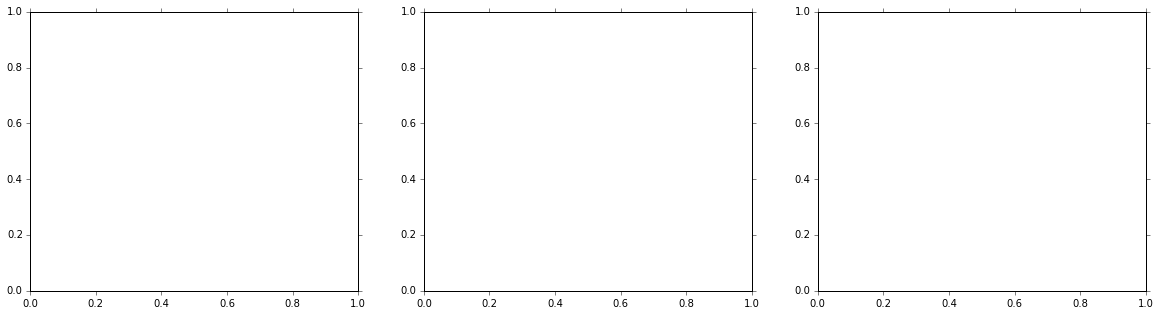

In [55]:
f,(ax1,ax2,ax3) = pl.subplots(1,3,figsize=[20,5])
im1 = ax1.imshow(corrMatrices[0]);
im2 = ax2.imshow(corrMatrices[1]);
im3 = ax3.imshow(corrMatrices[2])
ax1.set_title('Sleep PRE')
ax2.set_title('LinearTrack')
ax3.set_title('Sleep POST')
pl.colorbar(im1);

In [128]:
N = pre.id_list.size
lMax = []
for item in Qs:
    lMax.append(np.math.pow(1 + np.math.sqrt(N/item.size),2))
    print item.size
TW_limit =  np.math.pow(N,-0.6666666666)

1513260
755790
1518762


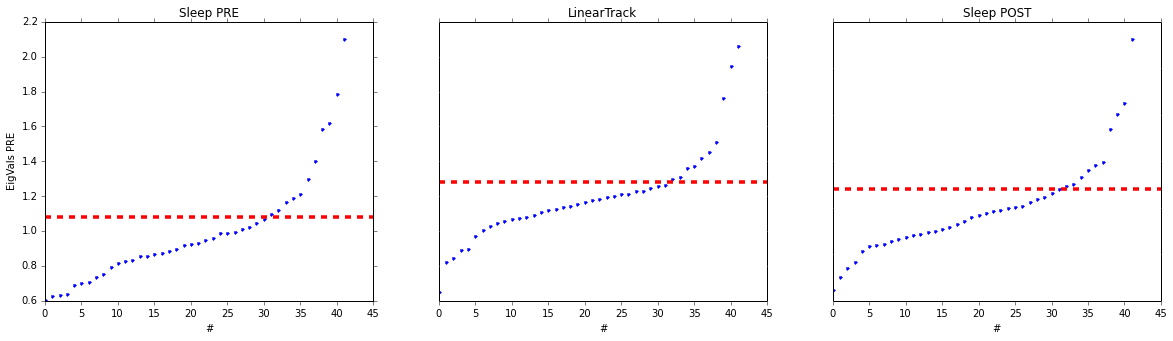

In [129]:
f,(ax1,ax2,ax3) = pl.subplots(1,3,figsize=[20,5])
ax1.plot(eigVals[0],'.')
#ax1.axhline(lMax[0],color = 'k')
ax1.axhline(lMax[0]+TW_limit,color = 'r',linestyle='--')
ax2.plot(eigVals[1],'.')
ax2.axhline(lMax[1]+TW_limit,color = 'r',linestyle='--')
ax3.plot(eigVals[2],'.')
ax3.axhline(lMax[2]+TW_limit,color = 'r',linestyle='--')
ax1.set_ylabel('EigVals PRE')
ax1.set_xlabel('#')
ax2.set_ylabel('EigVals LinearTrack')
ax2.set_xlabel('#')
ax3.set_ylabel('EigVals POST')
ax3.set_xlabel('#')
ax1.set_title('Sleep PRE')
ax2.set_title('LinearTrack')
ax3.set_title('Sleep POST')
ax2.yaxis.label.set_color('white')
ax2.tick_params(axis='y', colors='white')
ax3.yaxis.label.set_color('white')
ax3.tick_params(axis='y', colors='white')

In [130]:
Gamma = []
for ii in range(3):
    G = []
    for jj in range(N):
        G.append(eigVecs[1][jj].T.dot(corrMatrices[ii]).dot(eigVecs[1][jj]))
    Gamma.append(np.array(G))

In [131]:
TW_limit,np.where(eigVals[2]>lMax[2]+TW_limit)

(0.0827625391845857, (array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41]),))

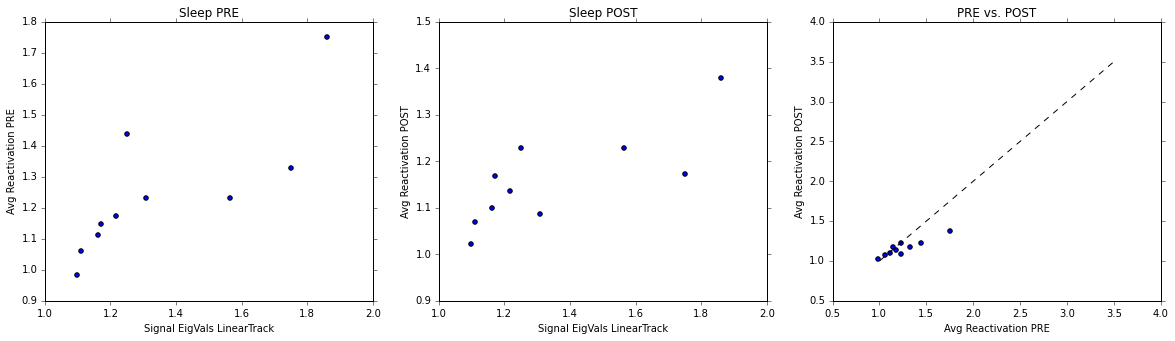

In [140]:
f,(ax1,ax2,ax3) = pl.subplots(1,3,figsize=[20,5])
ax1.scatter(eigVals[1][32:],Gamma[0][32:])
ax2.scatter(eigVals[1][32:],Gamma[2][32:])
ax3.scatter(Gamma[0][32:],Gamma[2][32:])
ax3.plot([1,3.5],[1,3.5],'k--', lw=1)
ax1.set_ylabel('Avg Reactivation PRE')
ax1.set_xlabel('Signal EigVals LinearTrack')
ax2.set_ylabel('Avg Reactivation POST')
ax2.set_xlabel('Signal EigVals LinearTrack')
ax3.set_ylabel('Avg Reactivation POST')
ax3.set_xlabel('Avg Reactivation PRE')
ax1.set_title('Sleep PRE')
ax2.set_title('Sleep POST')
ax3.set_title('PRE vs. POST')

In [137]:
k = 0
for ii in range(N):
    for jj in range(N):
        k += Qs[0][ii]*Ps[2][N - 1][ii,jj]*Qs[0][jj]
kk = 0
for ii in range(N):
    for jj in range(N):
        kk += Qs[2][ii]*Ps[2][N - 1][ii,jj]*Qs[2][jj]

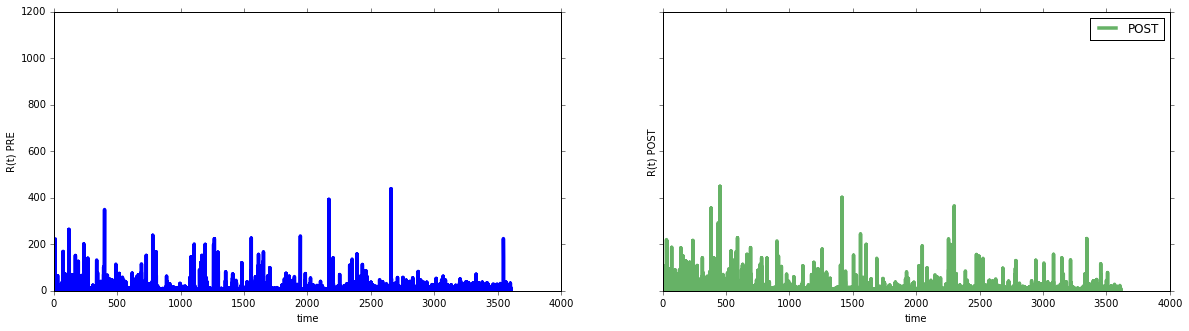

In [139]:
f,(ax1,ax2) = pl.subplots(1,2,figsize=[20,5],sharey=True)
ax1.plot(np.arange(Qs[0][1].size)/10,k)
ax2.plot(np.arange(Qs[2][1].size)/10,kk,'g',alpha=0.6,label = 'POST')
ax1.set_ylim([0,1200])
ax1.set_ylabel('R(t) PRE')
ax1.set_xlabel('time')
ax2.set_ylabel('R(t) POST')
ax2.set_xlabel('time')
pl.legend()

In [142]:
reactivationStrengths = np.array([Gamma[0][32:],Gamma[2][32:]])

In [154]:
pkl.dump(reactivationStrengths,open(WorkPath+'rat3656D1.cnt','wb'),pkl.HIGHEST_PROTOCOL)